In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
agg_news = pd.read_csv('agg_ffill_news.csv', index_col = 0)
price = pd.read_csv('unagg_ffill_price.csv', index_col = 0)

In [3]:
ffill = agg_news.merge(price, how = 'inner', on = ['ticker', 'day'])

In [4]:
ffill.drop(['date_x', 'date_y'], axis = 1, inplace = True)

In [5]:
ffill.dropna(inplace = True)

In [6]:
ffill_train = ffill[pd.to_datetime(ffill['day']) <= datetime.datetime(2017,5,3)]
ffill_validation = ffill[(pd.to_datetime(ffill['day']) >= datetime.datetime(2017,5,4)) & \
                                 (pd.to_datetime(ffill['day']) <= datetime.datetime(2018,4,4))]
ffill_test = ffill[pd.to_datetime(ffill['day']) >= datetime.datetime(2018,4,5)]

In [7]:
ffill_train['open_price_change_direction'] = np.where(ffill_train['open_price_change'] >= 0, 1, 0)
ffill_validation['open_price_change_direction'] = np.where(ffill_validation['open_price_change'] >= 0, 1, 0)
ffill_test['open_price_change_direction'] = np.where(ffill_test['open_price_change'] >= 0, 1, 0)

D:\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

## Lasso Regression

In [8]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
scaler.fit(ffill_train.drop(['ticker', 'day', 'open_price_change', 'open_price_change_direction'], axis = 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
scaler_columns = [column for column in ffill_train.columns if column\
                 not in ['ticker', 'day', 'open_price_change', 'open_price_change_direction']]

In [11]:
ffill_train_scale = pd.DataFrame(scaler.transform\
                                 (ffill_train.drop(['ticker', 'day', 'open_price_change', 'open_price_change_direction'], \
                                                   axis = 1)), columns = scaler_columns)
ffill_validation_scale = pd.DataFrame(scaler.transform\
                                 (ffill_validation.drop(['ticker', 'day', 'open_price_change', 'open_price_change_direction'], \
                                                   axis = 1)), columns = scaler_columns)

ffill_test_scale = pd.DataFrame(scaler.transform\
                                 (ffill_test.drop(['ticker', 'day', 'open_price_change', 'open_price_change_direction'], \
                                                   axis = 1)), columns = scaler_columns)

In [12]:
ffill_mse = 10000
ffill_alpha = 0

for alpha in [0.01, 0.05, 0.1, 0.5, 1]:

    lasso = Lasso(alpha = alpha)
    lasso.fit(ffill_train_scale, ffill_train['open_price_change'])
    mse = mean_squared_error(ffill_validation['open_price_change'], lasso.predict(ffill_validation_scale))
    if mse < ffill_mse:
        ffill_mse = mse
        ffill_alpha = alpha

In [13]:
print('validation_mse is '+str(ffill_mse))

validation_mse is 0.00022148770972333083


In [14]:
lasso = Lasso(alpha = ffill_alpha)
lasso.fit(ffill_train_scale, ffill_train['open_price_change'])
test_ffill_mse = mean_squared_error(ffill_test['open_price_change'], lasso.predict(ffill_test_scale))

In [15]:
print('test_mse is '+str(test_ffill_mse))

test_mse is 0.00018236227409923467


In [16]:
target_sign = np.sign(ffill_test['open_price_change'])
target_sign[target_sign == 0] = 1.0

prediction_sign = np.sign(lasso.predict(ffill_test_scale))
prediction_sign[prediction_sign == 0] = 1.0

In [17]:
test_accuracy = ((np.abs(target_sign + prediction_sign)).sum() / 2) / target_sign.shape[0]
print('test_direction_accuracy is ' + str(test_accuracy))

test_direction_accuracy is 0.5716247139588101


In [18]:
from sklearn.metrics import mean_absolute_error
test_ffill_mae = mean_absolute_error(ffill_test['open_price_change'], lasso.predict(ffill_test_scale))
print('test_mae is '+str(test_ffill_mae))

test_mae is 0.009615461909314548


In [19]:
np.unique(prediction_sign, return_counts = True)

(array([1.]), array([2185], dtype=int64))

In [20]:
prediction = lasso.predict(ffill_test_scale)

In [21]:
ffill_test['price_prediction'] = prediction

D:\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
ffill_test['not_normal_return'] = ffill_test['open_price_change'] * ffill_test['price_prediction']

D:\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
ffill_test

,ticker,day,event_impact_gt_mu_pos_add_sigma_pos_avg,event_impact_gt_mu_pos_add_sigma_pos_sum,event_impact_gt_mu_pos_add_sigma_pos_min,event_impact_gt_mu_pos_add_sigma_pos_max,event_impact_lt_mu_sub_sigma_avg,event_impact_lt_mu_sub_sigma_sum,event_impact_lt_mu_sub_sigma_min,event_impact_lt_mu_sub_sigma_max,...,adj_close,close,high,low,open,volume,open_price_change,open_price_change_direction,price_prediction,not_normal_return
1109,AAPL,2018-04-05,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,168.91,172.80,174.23,172.08,172.58,26933200.0,-0.006375,0,0.000658,-4.193991e-06
1110,AAPL,2018-04-06,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,164.59,168.38,172.48,168.20,170.97,35005300.0,0.018366,1,0.000658,1.208184e-05
1111,AAPL,2018-04-09,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,166.23,170.05,173.09,169.85,169.88,29017700.0,-0.004451,0,0.000658,-2.927962e-06
1112,AAPL,2018-04-10,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,169.35,173.25,174.00,171.53,173.00,28408600.0,0.006851,1,0.000658,4.507068e-06
1113,AAPL,2018-04-11,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,168.56,172.44,173.92,171.70,172.23,22431600.0,0.007900,1,0.000658,5.197175e-06
1114,AAPL,2018-04-12,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,170.22,174.14,175.00,173.04,173.41,22889300.0,0.001430,1,0.000658,9.409557e-07
1115,AAPL,2018-04-13,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,170.80,174.73,175.84,173.85,174.78,25124300.0,0.008341,1,0.000658,5.487332e-06
1116,AAPL,2018-04-16,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,171.87,175.82,176.19,174.83,175.03,21578400.0,0.007479,1,0.000658,4.920109e-06
1117,AAPL,2018-04-17,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,174.23,178.24,178.94,176.41,176.49,26605400.0,-0.022777,0,0.000658,-1.498372e-05
1118,AAPL,2018-04-18,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,173.84,177.84,178.82,176.88,177.81,20754500.0,-0.018186,0,0.000658,-1.196350e-05


In [24]:
return_table = ffill_test.groupby('day', as_index = False)['not_normal_return'].sum()
return_table['normalization'] = ffill_test.groupby('day', as_index = False)['price_prediction'].sum()['price_prediction']

In [25]:
return_table['return'] = return_table['not_normal_return'] / return_table['normalization']

In [26]:
sharpe = (return_table['return'].mean() / return_table['return'].std()) * np.sqrt(250)

In [27]:
print(sharpe)

2.312903645193244


In [43]:
return_plot = (return_table['return'] + 1).cumprod().tolist()
return_plot.insert(0,1)

Text(55, 0.98, 'Annual Sharpe ratio = 2.3129036')

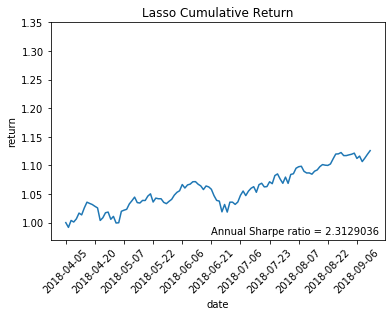

In [56]:
plt.title('Lasso Cumulative Return')
plt.xlabel('date')
plt.ylabel('return')
plt.ylim(0.97, 1.35)
plt.plot(return_plot)
plt.xticks(np.arange(0,115,11), return_table['day'][0:115:11], rotation = 45)
plt.text(55, 0.98, 'Annual Sharpe ratio = 2.3129036')